In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import scipy.stats as stats
import io

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
ab_data = pd.read_csv('drive/My Drive/Colab Notebooks/DATA/ab_data.csv',delimiter=",")
ab_data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


# Cleansing Data

In [ ]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


dari data diatas dapat kita lihat bahwa datatype kolom timestamp adalah object sehingga perlu diubah ke dalam bentuk datatype datetime

In [ ]:
#change datatypes
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


datatype kolom timestamp sudah berubah menjadi datetime

In [ ]:
ab_data['user_id'].nunique()

290584

In [ ]:
ab_data.shape[0]

294478

Dapat dilihat bahwa jumlah unique row lebih banyak dari unique user

In [ ]:
#memunculkan data yg hanya berisi nilai treatment pada kolom group
datatreatment= ab_data[ab_data['group'].str.contains('treatment')]
datatreatment

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
...,...,...,...,...,...
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0


In [ ]:
#memunculkan data yg hanya berisi nilai control pada kolom group
datatreatment= ab_data[ab_data['group'].str.contains('control')]
datatreatment

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0


In [ ]:
total_page = ab_data.groupby(by='group')['group'].agg('count').to_frame('count')
total_page

,count
group,
control,147202
treatment,147276


Dapat dilihat masing-masing jumlah total dari data control dan treatment pada kolom group. Serta dapat dilihat bahwa data yang berisi treatment pada kolom group memiliki landing page baru sedangkan data yang berisi control pada kolom group memilki landing page lama

In [ ]:
#menghapus jika ada nilai treatment yang tidak cocok dengan new page dan nilai control yang tidak cocok dengan old page
notsame= ab_data[((ab_data['group']=='treatment')==(ab_data['landing_page']=='new_page'))== False].index
ab_data=ab_data.drop(notsame)
ab_data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [ ]:
#memunculkan data duplicated yang ada pada user_id
ab_data[ab_data.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [ ]:
#hapus data duplicated yang ada
ab_data.drop_duplicates(subset='user_id',keep='first',inplace=True)
ab_data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [ ]:
print(ab_data.shape[0])
print(ab_data['user_id'].nunique())

290584
290584


In [ ]:
ab_data.shape

(290584, 5)

Setelah dihapus data yang duplikat maka jumlah user_id row dan jumlah unique row berjumlah sama

#  Analisis Eksplorasi Data

In [ ]:
#menampilkan statistik deskriptif dari data frame
ab_data.describe()

,user_id,converted
count,290584.000000,290584.000000
mean,788004.876222,0.119597
std,91224.735468,0.324490
min,630000.000000,0.000000
25%,709034.750000,0.000000
50%,787995.500000,0.000000
75%,866956.250000,0.000000
max,945999.000000,1.000000


In [ ]:
pd.crosstab([ab_data.group], ab_data.landing_page).style.background_gradient(vmin=0)

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145310,0


In [ ]:
total_page = ab_data.groupby(by=['landing_page','group'])['converted'].sum().reset_index()
total_page

,landing_page,group,converted
0,new_page,treatment,17264
1,old_page,control,17489


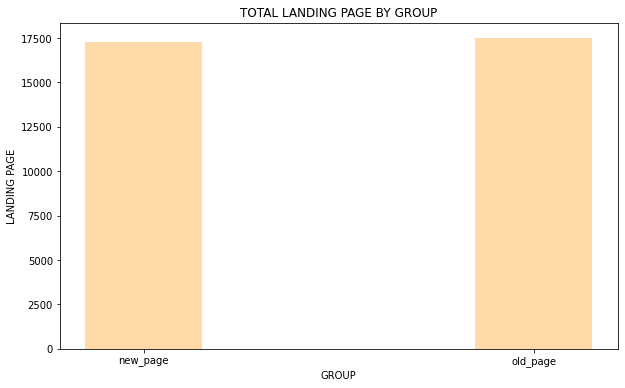

In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(total_page['landing_page'], total_page['converted'],width = 0.3, color='#ffdaa8')
plt.xlabel('GROUP')
plt.ylabel('LANDING PAGE')
plt.title('TOTAL LANDING PAGE BY GROUP')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


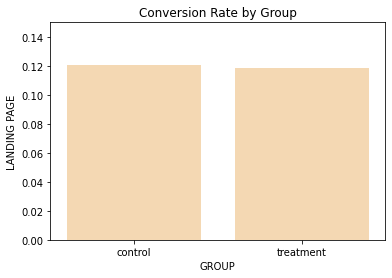

In [ ]:
sns.barplot(ab_data['group'], ab_data['converted'],ci=False, color='#ffdaa8')
plt.ylim(0, 0.15)
plt.xlabel('GROUP')
plt.ylabel('LANDING PAGE')
plt.title('Conversion Rate by Group')
plt.show()

dari 2 chart diatas dapat dilihat bahwa nilai antara new page dan old page ataupun control dan treatment memiliki nilai yang berbeda tipis. Selanjutnya kita melakukan pengecekan apakah perbedaan tersebut signifikan secara statistik

# A/B Test

In [ ]:
con=ab_data[ab_data['group']=='control']['converted']
treat=ab_data[ab_data['group']=='treatment']['converted']

con1=con.count()
treat1=treat.count()
success=[con.sum(),treat.sum()]
nobs_=[con1,treat1]

z_stat,p_val=proportions_ztest(success,nobs=nobs_)

In [ ]:
print(f'z statistic:{z_stat:.2f}')
print(f'p-value:{p_val:.3f}')

z statistic:1.31
p-value:0.190


Kesimpulan

Karena P-Value yang di dapatkan adalah 0.19 dan alpha = 0.05, maka dari itu tidak dapat menolak hipotesis nol (H0), yang artinya bahwa landing page baru atau design halaman baru tidak lebih baik dari landing page lama atau design halaman lama

H1=H0